In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf 
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras.layers import LSTM
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# from functions_forecasting import *

In [150]:
# data
ticker = 'TSLA'
start_date = '2010-01-02'
end_date = '2020-12-31'
n_lags = 3

valid_size = 12
test_size = 12
batch_size = 3
n_epochs = 1000

In [151]:
df = yf.download(ticker,
    start = start_date,
    end = end_date,
    progress = False)

df = df.resample('M').last()
prices = df['Adj Close'].values.reshape(-1, 1)

In [152]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    '''
    Function for transforming time series into input acceptable by multilayer perceptron.abs

    Parameters
    ----------
    series : np.array
        Array of features 
    n_steps_in : int
        The number of lagged observations to consider as features

    Returns 
    -------
    X : np.array 
        Array of features 
    Y : np.array 
        Array of features
    '''

    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        X.append(sequence[i:end_ix])
        y.append(sequence[end_ix:out_end_ix])
    return np.array(X), np.array(y)


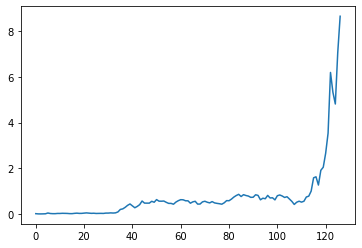

In [153]:
minmax = MinMaxScaler(feature_range=(0, 1))

prices_train = prices[:-valid_size]
prices_valid = prices[-valid_size:]

minmax.fit(prices_train)

prices_train = minmax.transform(prices_train)
prices_valid = minmax.transform(prices_valid)

prices_scaled = np.concatenate((prices_train, 
                                prices_valid)).flatten()
plt.plot(prices_scaled)

In [154]:
X, y = split_sequence(prices_scaled, 3,1)
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], 1)

In [155]:
X.shape

(124, 3, 1)

In [156]:
X_train = X[:-valid_size]
y_train = y[:-valid_size]

X_val = X[-valid_size:]
y_val = y[-valid_size:]
# val_data = np.array((X_val, y_val))

In [157]:
X_train.shape

(112, 3, 1)

In [158]:
class RNN(tf.keras.Model):

    def __init__(self,steps_in,steps_out):
        super(RNN, self).__init__()
        self.LSTM_layer1 = tf.keras.layers.LSTM(256,input_shape = (steps_in,1))
        # self.drop_out_layer_1 = tf.keras.layers.Dropout(0.2)
        self.LSTM_layer2 = tf.keras.layers.LSTM(256)
        # self.drop_out_layer_2 = tf.keras.layers.Dropout(0.2)
        self.dense_layer3 = tf.keras.layers.Dense(steps_out)

    # In the call function, we define the Model's forward pass.
    def build(self):
        model = tf.keras.Sequential([
        # Layer 1: 
        self.LSTM_layer1,
        # self.drop_out_layer_1,
        # Layer 2:
        # self.LSTM_layer2,
        # self.drop_out_layer_2,
        # Layer 3:
        self.dense_layer3 
        ])

        return model

In [159]:
model = RNN(3,1).build()
optimizer = tf.keras.optimizers.Adam(0.0001)
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 256)               264192    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [160]:
model(X_train[0:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00017837]], dtype=float32)>

In [161]:
mse = tf.keras.losses.MeanSquaredError()
# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [162]:
@tf.function
def train_step(x, y): 
    with tf.GradientTape() as tape:

        y_hat = model(x) 

        loss = mse(y, y_hat) 
        
        grads = tape.gradient(loss, model.trainable_variables) 

        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [163]:
model(X_train[0:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00017837]], dtype=float32)>

In [164]:
history = []
history_val = []
losses_val = []

for epoch in tqdm(range(5)):
    for i in range(len(X_train)):
        # Grab a batch and propagate it through the network
        x_batch, y_batch = X_train[i:i+1], y_train[i:i+1]
        loss = train_step(x_batch, y_batch)

        # Update the progress bar
        history.append(loss.numpy().mean())

        # Update validation loss history
        for j in range(len(X_val)):
            y_hat = model(X_train[j:j+1])
            losses_val.append( mse(y_hat, y_val[j:j+1]).numpy() )
            
        history_val.append(np.asarray(losses_val).mean())
        losses_val = []
      
model.save_weights(checkpoint_prefix)

100%|██████████| 5/5 [00:32<00:00,  6.57s/it]


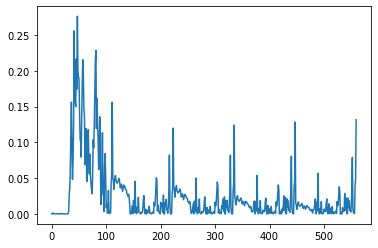

In [165]:
fig, ax = plt.subplots()
ax.plot(history)

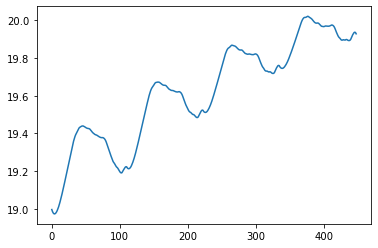

In [166]:
fig, ax = plt.subplots()
ax.plot(history_val[len(X_train):])

In [171]:

for i in tqdm(range(len(X_train))):
    # Grab a batch and propagate it through the network
    x_batch, y_batch = X_train[i:i+1], y_train[i:i+1]
    loss = train_step(x_batch, y_batch)

model.save_weights(checkpoint_prefix)

100%|██████████| 112/112 [00:00<00:00, 565.15it/s]


In [172]:
y_hat = model(X_val)

In [173]:
pedictions = y_hat.numpy().flatten()

Text(0, 0.5, 'Price ($)')

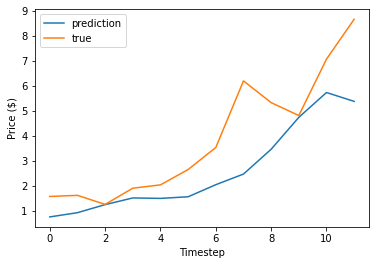

In [174]:
fig, ax = plt.subplots()
ax.plot(predictions, label='prediction')
ax.plot(y_val, label = 'true')
ax.legend()
ax.set_xlabel('Timestep')
ax.set_ylabel('Price ($)')